spatial autocorrelation

In [1]:
access = '/mica/mica1/03_projects/yigu/'

import os
if os.uname()[1] == 'Yigus-MacBook-Air.local':
    access = '/Users/yiguz/remoteaccess/'

In [2]:
import libpysal
import nibabel as nb
import numpy as np

surfdir = access + '/surfaces/'

src = {'L':surfdir + 'fsLR-32k/surf/fsLR-32k.L.surf.gii', 'R': surfdir + 'fsLR-32k/surf/fsLR-32k.L.surf.gii'}

# read surface information to construct mesh through pymesh
f32k = {'L': nb.load(src['L']), 'R': nb.load(src['R'])}

# construct spatial weights from adjacency dictionary
neighbours = np.load(surfdir + 'fsLR-32k/surf/fsLR-32k_L_neighbours.npy', allow_pickle=True)
neighbours = neighbours.item()

W = libpysal.weights.W(neighbours) # binary queen contiguity

In [3]:
# fetch maps
import neuromaps.datasets
#print(neuromaps.datasets.available_annotations())
fc1 = neuromaps.datasets.fetch_annotation(source = 'margulies2016', desc='fcgradient01')
myelin = neuromaps.datasets.fetch_annotation(source = 'hcps1200', desc = 'myelinmap')

map1 = nb.load(fc1[0]); map1 = map1.darrays[0].data
map2 = nb.load(myelin[0]); map2 = map2.darrays[0].data

global autocorrelation and spatial lag

In [4]:
# spatial lag
y1 = np.asarray(map1,dtype='float64')
y2 = np.asarray(map2,dtype='float64')
y_slag1 = libpysal.weights.lag_spatial(W, y1)
y_slag2 = libpysal.weights.lag_spatial(W, y2)

# Global Spatial Autocorrelation
import esda
I1 = esda.Moran(y=y1, w=W, transformation='r', permutations=1000)
I2 = esda.Moran(y=y2, w=W, transformation='r', permutations=1000)

/var/folders/8_/l747dmgs0vl46vqk2v5xs_jh0000gn/T/ipykernel_26406/1648595742.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


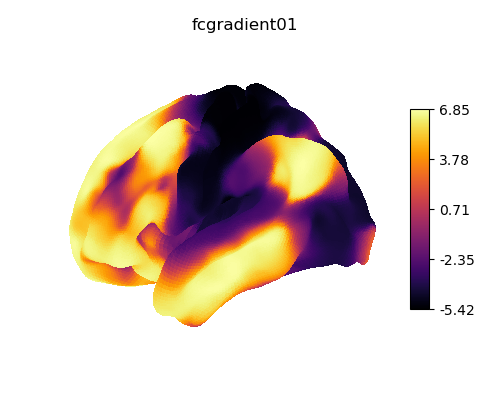

In [5]:
from nilearn.plotting import plot_surf

p = plot_surf(src['L'], y1, cmap = 'inferno', colorbar = True, cbar_tick_format='%1.2f')
p.suptitle('fcgradient01')
p.show()

/var/folders/8_/l747dmgs0vl46vqk2v5xs_jh0000gn/T/ipykernel_26406/2027617910.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


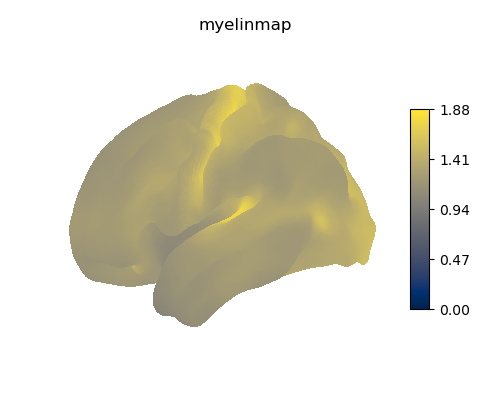

In [6]:
p = plot_surf(src['L'], y2, cmap = 'cividis', colorbar = True, cbar_tick_format='%1.2f')
p.suptitle('myelinmap')
p.show()

/var/folders/8_/l747dmgs0vl46vqk2v5xs_jh0000gn/T/ipykernel_26406/4072777300.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


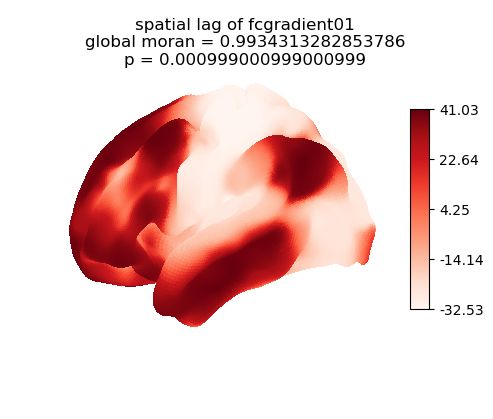

In [7]:
p = plot_surf(src['L'], y_slag1, colorbar=True, cmap = 'Reds', cbar_tick_format='%1.2f')
p.suptitle('spatial lag of fcgradient01\nglobal moran = ' + str(I1.I) + '\np = ' + str(I1.p_sim))
p.show()

/var/folders/8_/l747dmgs0vl46vqk2v5xs_jh0000gn/T/ipykernel_26406/121704117.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


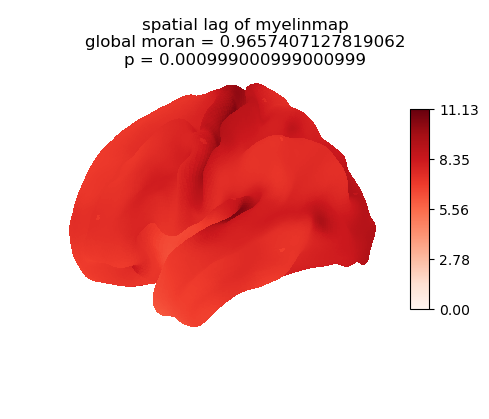

In [8]:
p = plot_surf(src['L'], y_slag2, colorbar=True, cmap = 'Reds', cbar_tick_format='%1.2f')
p.suptitle('spatial lag of myelinmap\nglobal moran = ' + str(I2.I) + '\np = ' + str(I2.p_sim))
p.show()

Text(0.5, 0, "Moran's I")

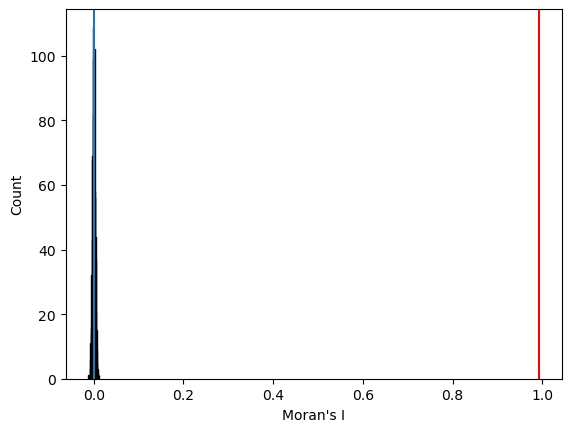

In [9]:
# null hypothesis = total spatial randomness

import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(I1.sim)
plt.axvline(I1.I, color='r')
plt.axvline(I1.EI)
plt.xlabel("Moran's I")

moran scatter plot for "spatial clustering"

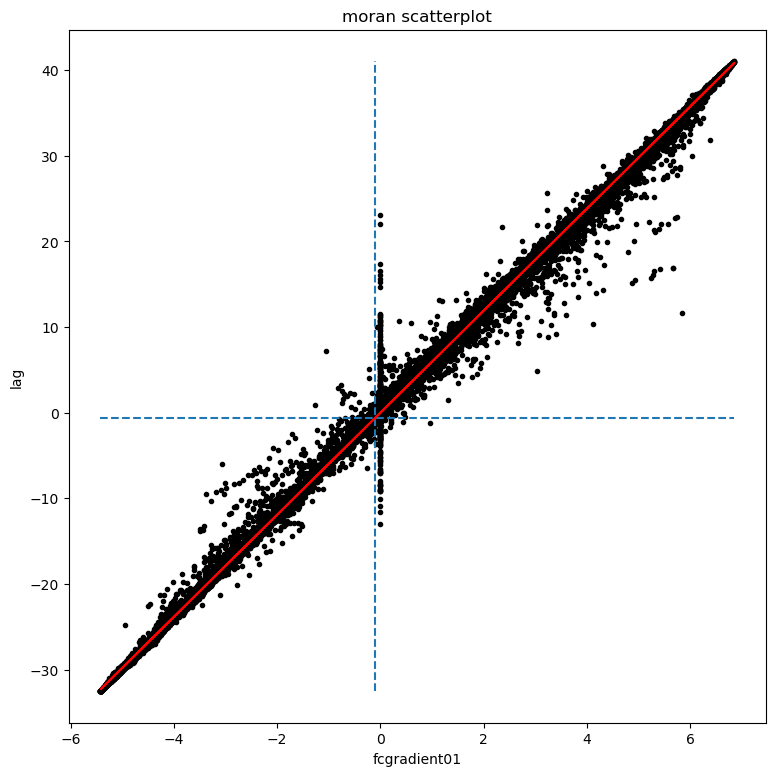

In [10]:
#plt.scatter(x=y, y=y_slag, color='k')
#plt.ylabel('lag'); plt.xlabel('attribute')

b, a = np.polyfit(y1, y_slag1, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(y1, y_slag1, '.', color = 'k')

# dashed vert at mean
plt.vlines(y1.mean(), y_slag1.min(), y_slag1.max(), linestyle='--')
# dashed horizontal at mean of lagged attribute
plt.hlines(y_slag1.mean(), y1.min(), y1.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(y1, a + b*y1, 'r')
plt.title('moran scatterplot')
plt.ylabel('lag')
plt.xlabel('fcgradient01')
plt.show()


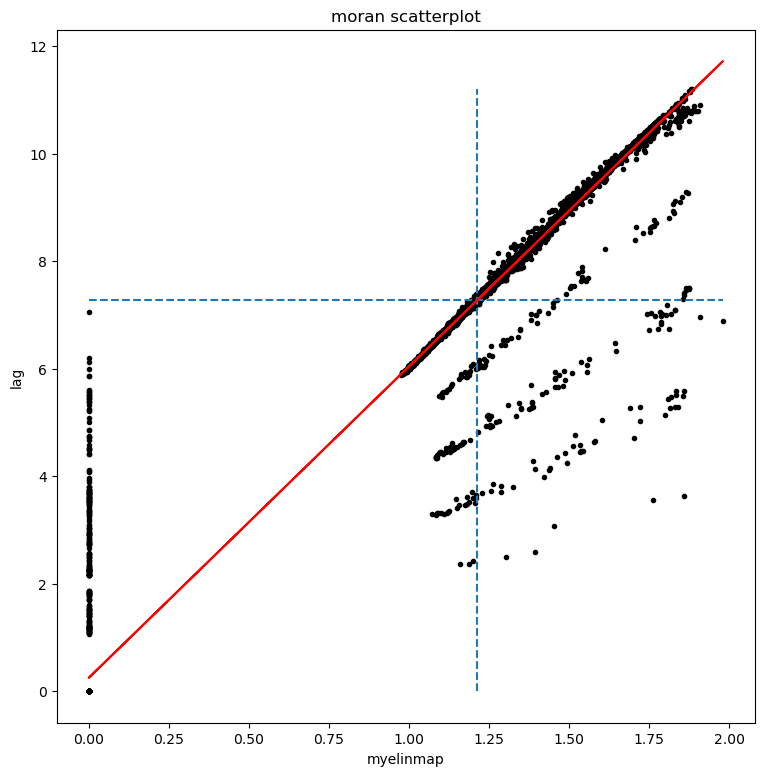

In [11]:

b, a = np.polyfit(y2, y_slag2, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(y2, y_slag2, '.', color = 'k')

# dashed vert at mean
plt.vlines(y2.mean(), y_slag2.min(), y_slag2.max(), linestyle='--')
# dashed horizontal at mean of lagged attribute
plt.hlines(y_slag2.mean(), y2.min(), y2.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(y2, a + b*y2, 'r')
plt.title('moran scatterplot')
plt.ylabel('lag')
plt.xlabel('myelinmap')
plt.show()

# ???? map has been artifically smoothed
# else why would you have 4 regimes of global autocorrelation?


/var/folders/8_/l747dmgs0vl46vqk2v5xs_jh0000gn/T/ipykernel_26406/4246020105.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


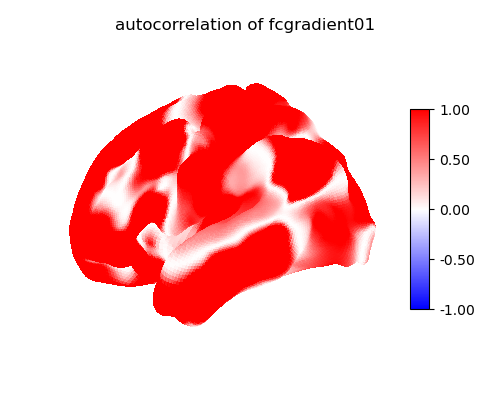

In [12]:
# local moran
local_I1 = esda.Moran_Local(y1, W)
p = plot_surf(src['L'], local_I1.Is, colorbar=True, cmap = 'bwr', vmin = -1, vmax = 1, cbar_tick_format='%1.2f')
p.suptitle('autocorrelation of fcgradient01')
p.show()

# looks right, queen contiguity weighting similar to distance matrix for meylin but pulls out stronger autocorrelation for gradient 1

/var/folders/8_/l747dmgs0vl46vqk2v5xs_jh0000gn/T/ipykernel_26406/1373948251.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


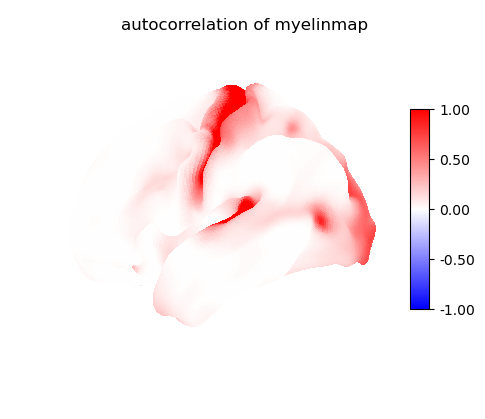

In [13]:
# local moran
local_I2 = esda.Moran_Local(y2, W)
p = plot_surf(src['L'], local_I2.Is, colorbar=True, cmap = 'bwr', vmin = -1, vmax = 1, cbar_tick_format='%1.2f')
p.suptitle('autocorrelation of myelinmap')
p.show()

Moran scatterplot for clustering

In [14]:
# quadrants !
# 1 - HH
# 2 - LH
# 3 - LL
# 4 - HL

#local_I.q
#(local_I1.p_sim < 0.05).sum()
(local_I2.p_sim < 0.05).sum()

9591

In [15]:
sig1 = local_I1.p_sim < 0.05
hotspot1 = sig1 * local_I1.q==1
coldspot1 = sig1 * local_I1.q==3
doughnut1 = sig1 * local_I1.q==2
diamond1 = sig1 * local_I1.q==4

In [16]:
sig2 = local_I2.p_sim < 0.05
hotspot2 = sig2 * local_I2.q==1
coldspot2 = sig2 * local_I2.q==3
doughnut2 = sig2 * local_I2.q==2
diamond2 = sig2 * local_I2.q==4

/var/folders/8_/l747dmgs0vl46vqk2v5xs_jh0000gn/T/ipykernel_26406/3659638334.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


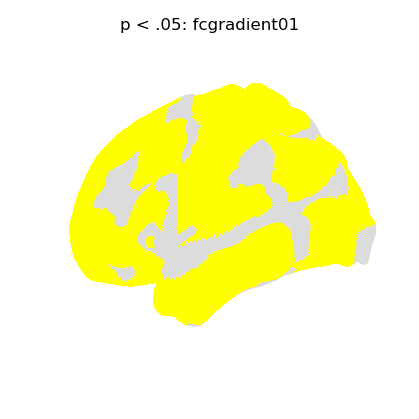

In [17]:
import matplotlib.colors

significant = matplotlib.colors.ListedColormap(['gainsboro', 'yellow'])

p = plot_surf(src['L'], sig1, cmap = significant)
p.suptitle('p < .05: fcgradient01')
p.show()

/var/folders/8_/l747dmgs0vl46vqk2v5xs_jh0000gn/T/ipykernel_26406/1979445686.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


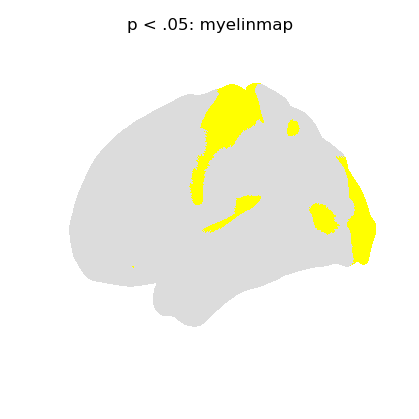

In [18]:
significant = matplotlib.colors.ListedColormap(['gainsboro', 'yellow'])

p = plot_surf(src['L'], sig2, cmap = significant)
p.suptitle('p < .05: myelinmap')
p.show()

/var/folders/8_/l747dmgs0vl46vqk2v5xs_jh0000gn/T/ipykernel_26406/1857690303.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


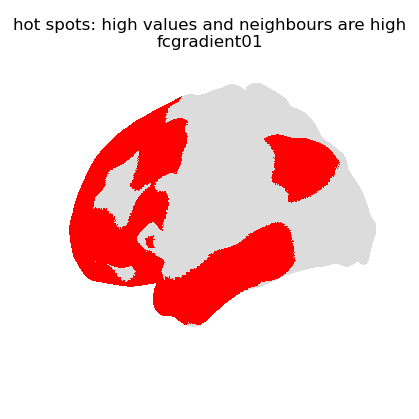

In [19]:
hot = matplotlib.colors.ListedColormap(['gainsboro', 'r'])

p = plot_surf(src['L'], hotspot1, cmap = hot)
p.suptitle('hot spots: high values and neighbours are high\nfcgradient01')
p.show()

/var/folders/8_/l747dmgs0vl46vqk2v5xs_jh0000gn/T/ipykernel_26406/3158730904.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


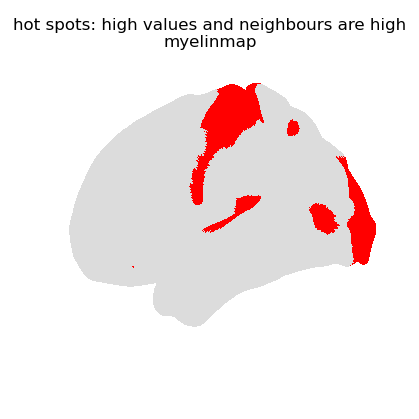

In [20]:
p = plot_surf(src['L'], hotspot2, cmap = hot)
p.suptitle('hot spots: high values and neighbours are high\nmyelinmap')
p.show()

/var/folders/8_/l747dmgs0vl46vqk2v5xs_jh0000gn/T/ipykernel_26406/109868973.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


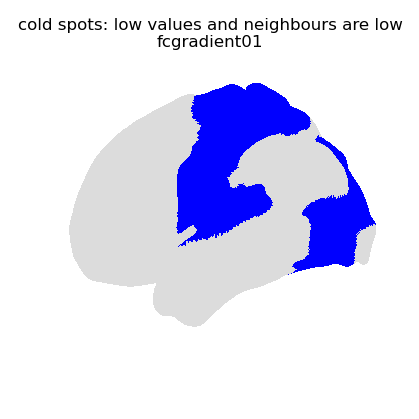

In [21]:
cold = matplotlib.colors.ListedColormap(['gainsboro', 'b'])

p = plot_surf(src['L'], coldspot1, cmap = cold)
p.suptitle('cold spots: low values and neighbours are low\nfcgradient01')
p.show()

/var/folders/8_/l747dmgs0vl46vqk2v5xs_jh0000gn/T/ipykernel_26406/2628061784.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


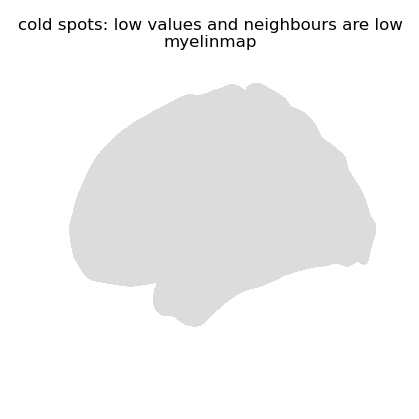

In [22]:
p = plot_surf(src['L'], coldspot2, cmap = cold)
p.suptitle('cold spots: low values and neighbours are low\nmyelinmap')
p.show()

/Users/yiguz/anaconda3/lib/python3.11/site-packages/nilearn/plotting/surf_plotting.py:512: RuntimeWarning: invalid value encountered in divide
  data_copy /= (vmax - vmin)
/var/folders/8_/l747dmgs0vl46vqk2v5xs_jh0000gn/T/ipykernel_26406/2334262389.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


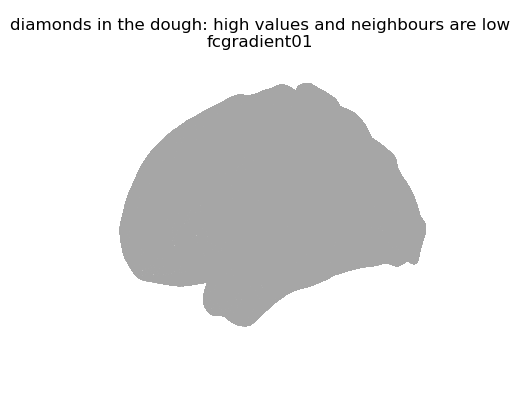

In [23]:
pink = matplotlib.colors.ListedColormap(['gainsboro', 'hotpink'])

p = plot_surf(src['L'], diamond1, cmap = pink)
p.suptitle('diamonds in the dough: high values and neighbours are low\nfcgradient01')
p.show()

/var/folders/8_/l747dmgs0vl46vqk2v5xs_jh0000gn/T/ipykernel_26406/3235596948.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


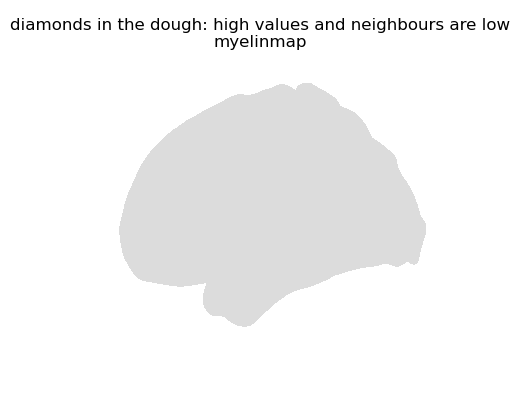

In [24]:
p = plot_surf(src['L'], diamond2, cmap = pink)
p.suptitle('diamonds in the dough: high values and neighbours are low\nmyelinmap')
p.show()

/var/folders/8_/l747dmgs0vl46vqk2v5xs_jh0000gn/T/ipykernel_26406/2748302279.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


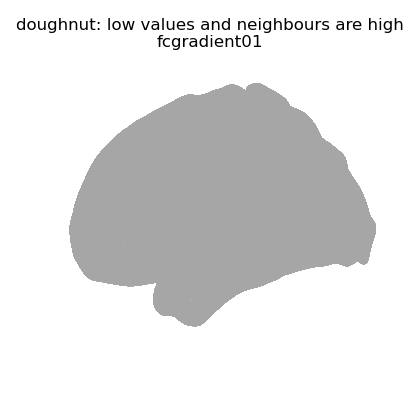

In [25]:
cyan = matplotlib.colors.ListedColormap(['gainsboro', 'cyan'])

p = plot_surf(src['L'], doughnut1, cmap = cyan)
p.suptitle('doughnut: low values and neighbours are high\nfcgradient01')
p.show()

/var/folders/8_/l747dmgs0vl46vqk2v5xs_jh0000gn/T/ipykernel_26406/510061749.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


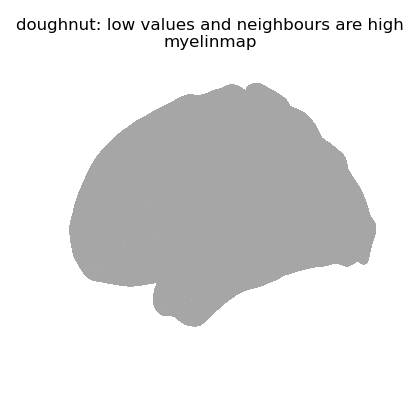

In [26]:
p = plot_surf(src['L'], doughnut2, cmap = cyan)
p.suptitle('doughnut: low values and neighbours are high\nmyelinmap')
p.show()